[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/peteyeh/celltrack/HEAD?labpath=feature_extraction.ipynb)

In [1]:
%matplotlib inline

import cv2
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import six

from collections import Counter, OrderedDict
from radiomics import featureextractor
from scipy import stats
from SimpleITK import GetImageFromArray
from skimage.filters import threshold_multiotsu
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from displaytools import *
from improcessing import *

extractor = featureextractor.RadiomicsFeatureExtractor()
# Enable everything but shape (3D) and glcm.SumAverage
extractor.disableAllFeatures()
extractor.enableFeaturesByName(firstorder=[],
                               shape2D=[],
                               glcm=['Autocorrelation', 'JointAverage', 'ClusterProminence',
                                     'ClusterShade', 'ClusterTendency', 'Contrast',
                                     'Correlation', 'DifferenceAverage', 'DifferenceEntropy',
                                     'DifferenceVariance', 'JointEnergy', 'JointEntropy',
                                     'Imc1', 'Imc2', 'Idm', 'Idmn', 'Id', 'Idn',
                                     'InverseVariance', 'MaximumProbability', 'SumEntropy',
                                     'SumSquares'],
                               glszm=[],
                               glrlm=[],
                               ngtdm=[],
                               gldm=[])

scaler = StandardScaler()
pca = PCA(n_components='mle')
tsne = TSNE(learning_rate='auto', init='pca', random_state=0)

# Display Tools

In [2]:
# Crops image to a region of interest
def crop_image(image):
    x, y, w, h = cv2.boundingRect(image)
    return image[y:y+h, x:x+w]

def display_classifications(image, centroids, labels):
    plt.figure(dpi=240)
    plt.axis('off')
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.scatter(*zip(*centroids), s=20, c=labels, marker='+', cmap=colormap, linewidths=0.75)
    plt.show()

def display_contours(image, masks, labels):
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    for i in range(len(masks)):
        mask = masks[i]
        color = np.array(matplotlib.colors.to_rgb(colormap.colors[labels[i]]))*255
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        image = cv2.drawContours(image, contours, contourIdx=-1, color=color, thickness=1)
    display_image(image)
    
def display_rois(image, masks, labels):
    for c in range(labels.min(), labels.max()+1):
        indices = np.where(labels==c)[0]
        print("Class %i, with %i ROIs:" % (c, len(indices)))
        masked = image*masks[indices]
        cropped = list(map(crop_image, masked))
        display_image_array(cropped, columns=10, dpi=150)

def display_tsne(df):
    transformed = tsne.fit_transform(df)
    plt.scatter(transformed[:,0], transformed[:,1], s=5, c=labels)
    plt.show()

def print_classification_counts(labels):
    c = Counter(labels)
    for k in sorted(c):
        print("Class %s (%s): %i (%.2f%%)" %
              (k, colormap.colors[k], c[k], c[k]*100/sum(c.values())))

# Iteration Logic

In [3]:
def extract_features(image, mask_image, size_thresh=75):
    num_components, labelled, stats, centroids = \
            cv2.connectedComponentsWithStats(mask_image, connectivity=8)

    features = OrderedDict()
    masks = []

    for i in range(1, len(stats)):  # index 0 is the background component
        size = stats[i, -1]
        if size < size_thresh:
            continue
        mask = np.uint8(labelled == i)
        masks += [mask,]
        result = extractor.execute(GetImageFromArray(image),
                                   GetImageFromArray(mask))
        if len(features) == 0:
            features['x'] = [int(centroids[i][0])]
            features['y'] = [int(centroids[i][1])]
            for key, val in six.iteritems(result):
                if key.startswith("original_"):
                    features[key] = [val]
        else:
            features['x'] += [int(centroids[i][0])]
            features['y'] += [int(centroids[i][1])]
            for key, val in six.iteritems(result):
                if key.startswith("original_"):
                    features[key] += [val]

    return pd.DataFrame.from_dict(features).set_index(['x', 'y']), np.array(masks)

def get_mask_image(image, params, mode="thresh_adaptive", verbose=False):
    if verbose:
        print("Using mode '%s'." % mode)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        hist1 = cv2.calcHist([image], [0], None, [256], [0,256])
        ax1.plot(hist1)
        ax1.set_title("Raw Image")
        ax1.set_xlim([0,256])
        ax1.set_ylim([0,hist1.max()])
        
    # Save a processed image for later
    # Note that these parameters are intentionally hard-coded
    if params['canny_unmasking']:
        enhanced = apply_contrast(image, 2)  # hard-coded factor
        canny = apply_canny(enhanced, 40, 180)
        canny_filled = apply_imfill(apply_closure(canny, 5))

    if params['denoise_pre']:
        if verbose:
            print("Denoising with intensity %i." % params['denoise_pre'])
        image = apply_denoise(image, params['denoise_pre'])

    if params['contrast']:
        if verbose:
            print("Enhancing contrast by factor of %.2f." % params['contrast'])
        image = apply_contrast(image, params['contrast'])
    
    if params['clipLimit']:
        if verbose:
            print("Equalizing histogram.")
        image = cv2.createCLAHE(params['clipLimit'], tileGridSize=(8,8)) \
                   .apply(image)
    
    if params['denoise_post']:
        if verbose:
            print("Denoising with intensity %i." % params['denoise_post'])
        image = apply_denoise(image, params['denoise_post'])
        
    if mode == "background_filter":
        peak = cv2.calcHist([image], [0], None, [256], [0,256]).argmax()
        lower = peak - params['lower_width']
        upper = peak + params['upper_width']
        if verbose:
            print("Filtering background between values %i and %i." % (lower, upper))
        binarized = np.uint8((image < lower) | (image > upper))
    elif mode == "edge_canny":
        if verbose:
            print("Applying Canny with thresholds %i and %i." %
                  (params['threshold1'], params['threshold2']))
        image = apply_sharpen(image)
        binarized = apply_canny(image, params['threshold1'], params['threshold2'])
    elif mode == "edge_sobel":
        if verbose:
            print("Applying Sobel with kernel size of %i." % params['sobel_ks'])
        image = apply_sharpen(image)
        sobel = apply_sobel(image, params['sobel_ks'])
        _, binarized = cv2.threshold(sobel, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    elif mode == "kmeans":
        if verbose:
            print("Applying k-means with %i attempts." % params['attempts'])
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        _, labels, _ = cv2.kmeans(np.float32(raw_image.flatten()), 2, None, criteria,
                       params['attempts'], cv2.KMEANS_PP_CENTERS)
        binarized = np.uint8(labels.reshape(image.shape))
        if stats.mode(labels.flatten()).mode[0]:
            binarized = cv2.bitwise_not(binarized)  # POSSIBLE BUG, COMPARE TO (1 - binarized)
    elif mode == "thresh_adaptive":
        if verbose:
            print("Applying adaptive thresholding with kernel size of %i and C=%i." %
                  (params['thresh_ks'], params['C']))
        binarized = cv2.adaptiveThreshold(image, 255,
                                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY_INV,
                                          params['thresh_ks'], params['C'])
    elif mode == "thresh_otsu":
        if verbose:
            print("Applying Otsu's.")
        _, binarized = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    else:
        print("Invalid mask mode, aborting.")
        return None
    
    if params['size_thresh']:
        if verbose:
            print("Unmasking regions smaller than %i pixels." % params['size_thresh'])
        _, labelled, stats, _ = cv2.connectedComponentsWithStats(binarized, connectivity=8)
        for i in range(1, len(stats)):  # index 0 is the background component
            size = stats[i, -1]
            if size < params['size_thresh']:
                binarized = binarized * (1 - np.uint8(labelled == i))
    
    if params['canny_unmasking']:
        if verbose:
            print("Unmasking areas without edges using Canny(%i, %i)." %
                  (params['threshold1'], params['threshold2']))
        binarized = binarized & canny_filled
    
    if verbose:
        print("Closing with kernel size of %i." % params['closure_ks'])
    filled = apply_imfill(apply_closure(binarized, kernel_size=params['closure_ks']))
    
    if verbose:
        ax2.plot(cv2.calcHist([image], [0], None, [256], [0,256]))
        ax2.set_title("Preprocessed")
        ax2.set_xlim([0,256])
        ax2.set_ylim([0,hist1.max()])

        display_image_array([image, binarized, filled],
                            ["Preprocessed", "Binarized", "Filled"], columns=3, dpi=450)

    return filled

def process_features(df):
    return pd.DataFrame(pca.transform(scaler.transform(df.values)),
                        index=df.index)

# Image preprocessing parameters

In [4]:
mode = "thresh_adaptive"

params = {
    ##################################################
    ###### PREPROCESSING #############################
    ### set to 0 to disable ##########################

    'denoise_pre': 3,
    
    # background separation
    'contrast': 2,  # contrast boosting factor

    # histogram equalization
    'clipLimit': 0,  # contrast limit for clipping
    
    'denoise_post': 0,

    ##################################################

    ##################################################
    ###### BINARIZATION MODE #########################
    ### set `mode` to one of the following ###########
    ### other params will be ignored* ################

    # "background_filter"
    'lower_width': 10,  # distances from peak
    'upper_width': 10,
    
    # "edge_canny"
    # *used for Canny unmasking 
    'threshold1': 30,  # lower values are ignored
    'threshold2': 210, # middle values considered if
                       # connected to upper values
    
    # "edge_sobel"
    'sobel_ks': 5,
    
    # "kmeans"
    'attempts': 10,  # number of times to repeat
    
    # "thresh_adaptive"
    'thresh_ks': 151,
    'C': 8,
    
    # "thresh_otsu"
    # No params needed

    ##################################################
    
    # size threshold
    'size_thresh': 25,
    
    # unmask areas without edges
    # uses 'threshold1' and 'threshold2' above
    'canny_unmasking': True,
    
    # image closure kernel size
    'closure_ks': 3,
}

# Fit and classify on control image

## Create mask image and extract raw features

Using mode 'thresh_adaptive'.
Denoising with intensity 3.
Enhancing contrast by factor of 2.00.
Applying adaptive thresholding with kernel size of 151 and C=8.
Unmasking regions smaller than 25 pixels.
Unmasking areas without edges using Canny(30, 210).
Closing with kernel size of 3.


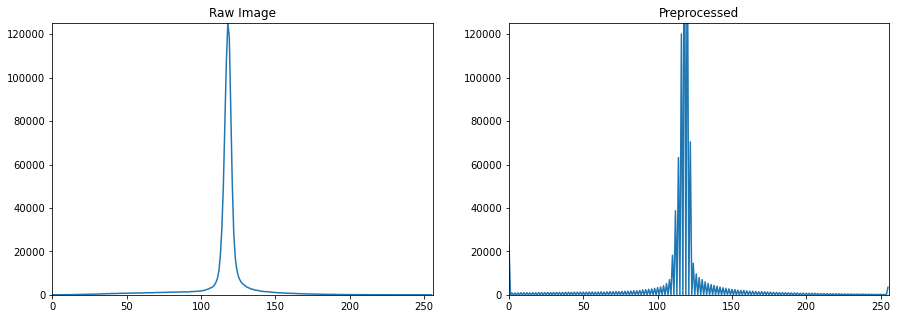

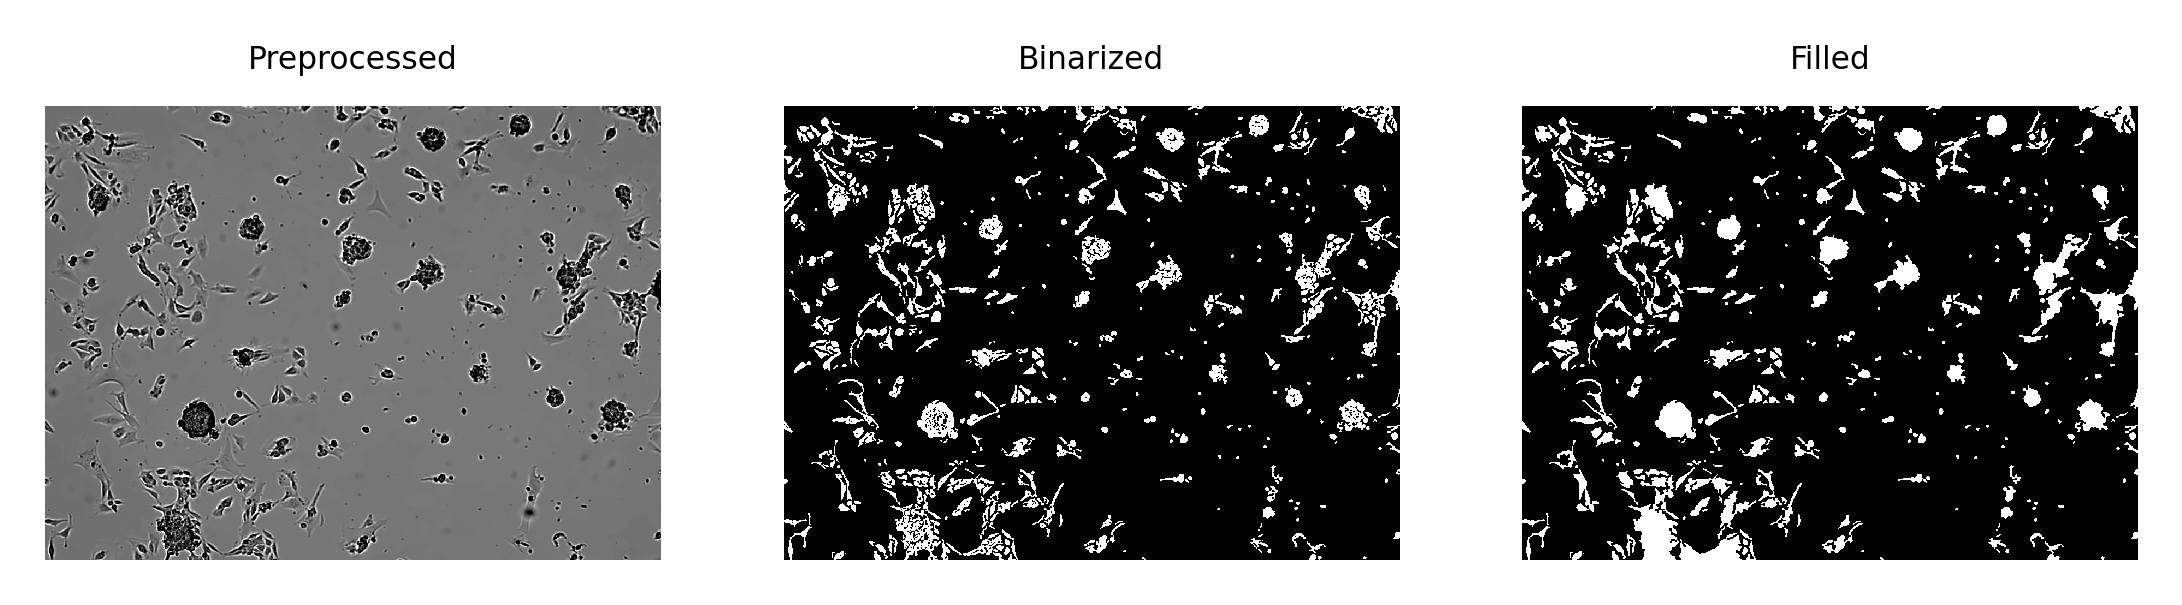

original_shape2D_Elongation  original_shape2D_MajorAxisLength  \
x   y                                                                    
391 8                       0.509617                         27.853167   
476 3                       0.626641                         15.657121   
541 14                      0.520329                         31.556165   
575 3                       0.397389                         25.371088   
621 7                       0.811047                         15.978203   
...                              ...                               ...   
419 817                     0.376886                         40.076285   
178 813                     0.327659                         33.107295   
407 815                     0.610092                         14.868964   
169 824                     0.590487                         18.759074   
100 824                     0.517924                         21.726223   

        original_shape2D_MaximumDiameter original_shape2D_MeshSurface  \
x   y                                                                   
391 8                  31.78049716414141                        254.5   
476 3                               17.0                        107.5   
541 14                30.528675044947494                        340.5   
575 3                 25.495097567963924                        185.5   
621 7                  17.08800749063506                        154.5   
...                                  ...                          ...   
419 817                 35.4400902933387                        217.5   
178 813                33.54101966249684                        221.5   
407 815               15.033296378372908                        102.5   
169 824                             20.0                        147.5   
100 824               23.430749027719962                        187.5   

         original_shape2D_MinorAxisLength original_shape2D_Perimeter  \
x   y                                                                  
391 8                           14.194446          89.45584412271575   
476 3                            9.811388         45.213203435596384   
541 14                          16.419583          88.76955262170053   
575 3                           10.082187           67.7989898732233   
621 7                           12.959069          52.62741699796948   
...                                   ...                        ...   
419 817                         15.104181         125.59797974644678   
178 813                         10.847917          94.08326112068531   
407 815                          9.071440           41.2132034355964   
169 824                         11.076993          53.55634918610403   
100 824                         11.252533         59.455844122715675   

        original_shape2D_PerimeterSurfaceRatio  original_shape2D_PixelSurface  \
x   y                                                                           
391 8                       0.3514964405607691                          255.0   
476 3                      0.42058793893578034                          108.0   
541 14                     0.26070353192863593                          341.0   
575 3                       0.3654932068637375                          186.0   
621 7                       0.3406305307311941                          155.0   
...                                        ...                            ...   
419 817                     0.5774619758457323                          218.0   
178 813                     0.4247551292130262                          222.0   
407 815                    0.40208003351801364                          103.0   
169 824                    0.36309389278714593                          148.0   
100 824                    0.31709783532115027                          188.0   

         original_shape2D_Sphericity original_firstorder_10Percentile  ...  \
x   y                      

In [5]:
raw_image = cv2.imreadmulti('source_images/Control.tif')[1][0]
mask_image = get_mask_image(raw_image, params, mode=mode, verbose=True)
df, masks = extract_features(raw_image, mask_image)
display(df)

## Scale features and reduce dimensions

In [6]:
scaler.fit(df.values)
pca.fit(df.values)

df = process_features(df)
display(df)

0             1             2           3           4   \
x   y                                                                       
391 8   -5.670307e+06 -12562.366817 -11474.862060 -395.548213 -170.040378   
476 3   -5.670307e+06 -12562.389368 -11475.723310 -394.630848 -170.781186   
541 14  -5.670307e+06 -12562.390364 -11475.708821 -394.583315 -170.902770   
575 3   -5.670307e+06 -12562.389503 -11475.727704 -394.627743 -170.736099   
621 7   -5.670307e+06 -12562.390778 -11475.756357 -394.598843 -170.914148   
...               ...           ...           ...         ...         ...   
419 817 -5.670307e+06 -12562.390158 -11475.748784 -394.595109 -170.769988   
178 813 -5.670307e+06 -12562.389955 -11475.730108 -394.601330 -170.797036   
407 815 -5.670307e+06 -12562.388621 -11475.719647 -394.649595 -170.587896   
169 824 -5.670307e+06 -12562.387634 -11475.682011 -394.705151 -170.609620   
100 824 -5.670307e+06 -12562.389735 -11475.700649 -394.609944 -170.804158   

                5           6           7           8         9   ...  \
x   y                                                             ...   
391 8   -53.762546  468.804314  124.773020  206.438523  1.098069  ...   
476 3   -54.311999  467.681807  124.251575  208.195294  1.885019  ...   
541 14  -54.445117  466.537314  124.256572  206.869470  2.127943  ...   
575 3   -54.297688  467.823710  124.458960  207.715852  1.992023  ...   
621 7   -54.452521  466.801874  124.098056  208.245352  2.190340  ...   
...            ...         ...         ...         ...       ...  ...   
419 817 -54.323274  467.645044  124.461089  207.239321  2.494071  ...   
178 813 -54.343914  467.431835  124.353607  207.363805  2.245799  ...   
407 815 -54.150038  468.755629  124.499067  207.712674  1.275101  ...   
169 824 -54.191359  468.525273  124.652937  208.080248  1.733382  ...   
100 824 -54.360149  467.276711  124.230495  207.555630  1.887853  ...   

               87        88        89        90        91        92        93  \
x   y                                                                           
391 8    0.410521  0.994558 -0.095517 -0.421463  0.014937  0.746231  2.102969   
476 3    0.252749  0.503686  0.310543  0.573032 -1.109420  1.023995  0.022918   
541 14   0.013936  0.014138 -0.870083  0.658209 -1.174340 -0.176903  0.531921   
575 3    0.355391  0.189701 -0.306515  0.400374 -1.378396  0.729442  0.423801   
621 7   -0.199732 -0.194880 -0.467485  0.914116 -1.683907  0.607148 -0.307368   
...           ...       ...       ...       ...       ...       ...       ...   
419 817 -0.121546 -0.044931 -0.143564  0.485514 -1.196664  0.691675 -0.069789   
178 813 -0.033981  0.064255  0.012880  0.502501 -1.396752  0.866570 -0.140424   
407 815  0.471046  0.487491  0.281021  0.185102 -1.252427  1.657479  0.586166   
169 824  0.194378  0.387782  1.042107  0.457287 -1.585650  2.398254 -0.533618   
100 824 -0.189005  0.285934 -0.307723  0.833738 -1.138980  0.481625  0.005213   

               94        95        96  
x   y                                  
391 8   -0.115526  0.064425  0.003239  
476 3   -0.230058  1.104609  0.216590  
541 14   0.184442  1.439412  0.274199  
575 3   -0.155969  1.054593  0.206662  
621 7   -0.085891  1.661441  0.315754  
...           ...       ...       ...  
419 817  0.120904  1.246666  0.246307  
178 813 -0.201013  1.306163  0.256737  
407 815 -0.425565  0.624628  0.123357  
169 824 -0.507351  0.963016  0.197808  
100 824  0.157914  1.431789  0.274410  

[200 rows x 97 columns]

## Determine number of clusters

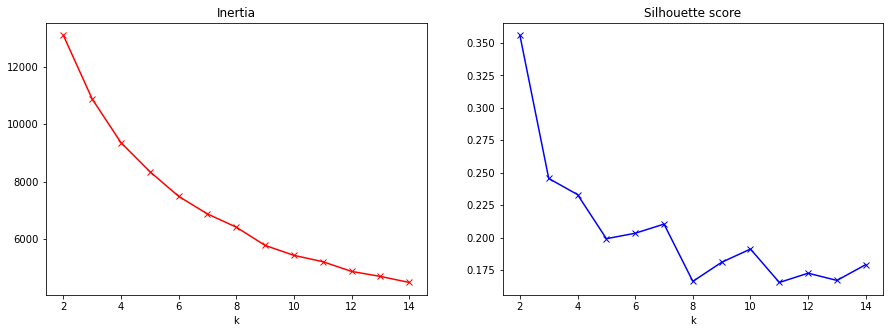

In [7]:
inertias = []
silhouette_scores = []
K = range(2, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(df)
    inertias += [kmeans.inertia_,]
    silhouette_scores += [silhouette_score(df, labels),]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(K, inertias, 'rx-')
ax1.set(xlabel='k', title="Inertia")
ax2.plot(K, silhouette_scores,'bx-')
ax2.set(xlabel='k', title="Silhouette score")
plt.show()

### User-defined values

In [8]:
# Manually select k based on visual inspection above
k = 2

# Classification colors (include k colors, or use colormap string)
colormap = matplotlib.colors.ListedColormap(['yellow', 'red'])

## Fit and classify using silhouette score

In [9]:
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(df)
labels = kmeans.predict(df)
print_classification_counts(labels)

Class 0 (yellow): 141 (70.50%)
Class 1 (red): 59 (29.50%)


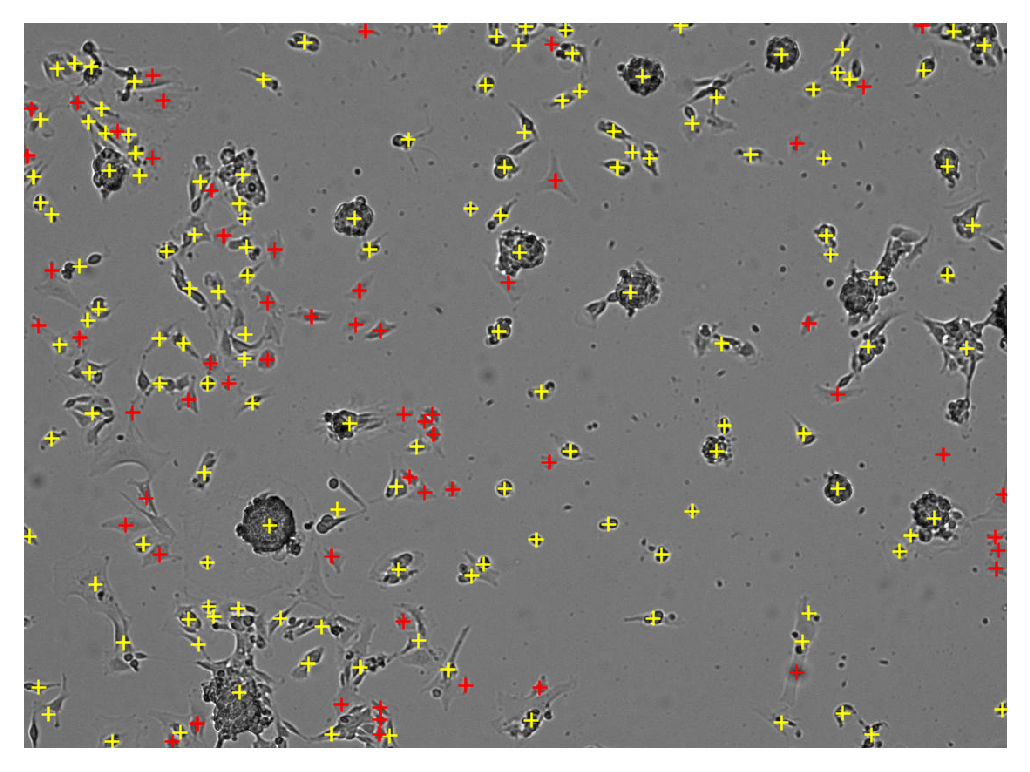

In [10]:
display_classifications(raw_image, df.index, labels)

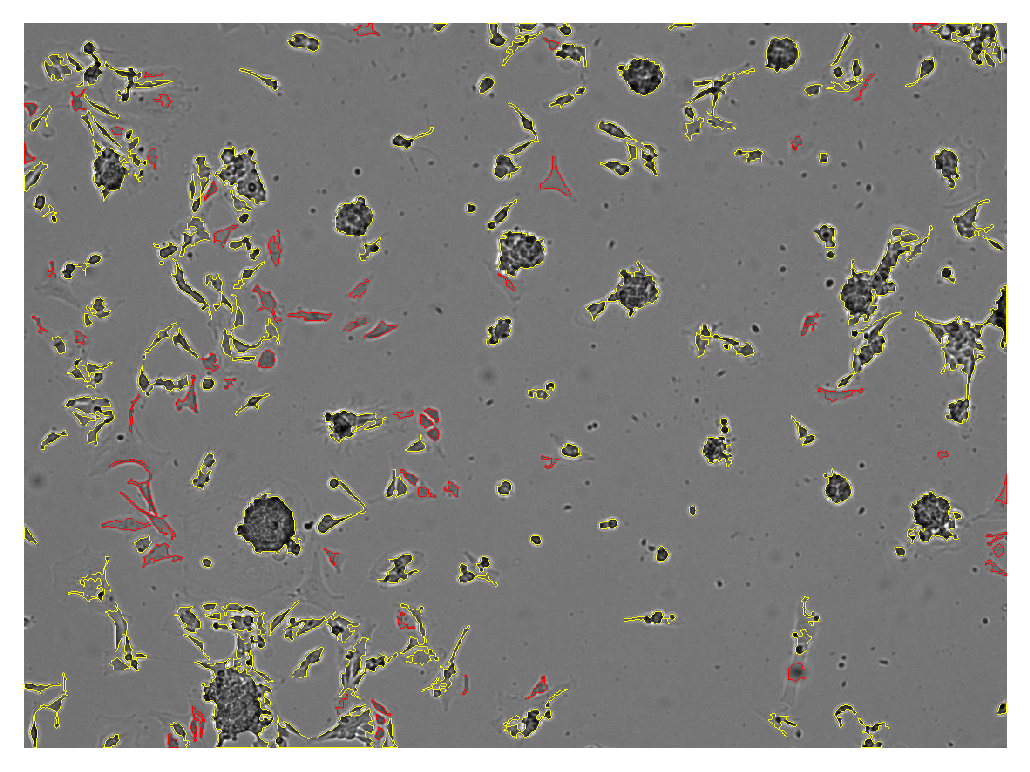

In [11]:
display_contours(raw_image, masks, labels)

Class 0, with 141 ROIs:


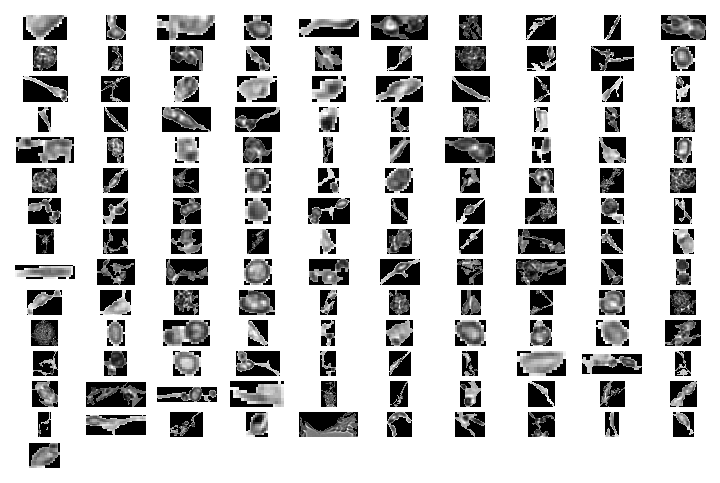

Class 1, with 59 ROIs:


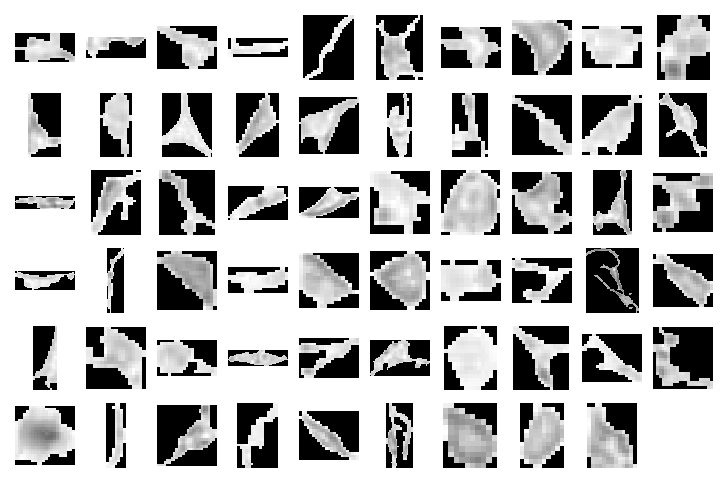

In [12]:
display_rois(raw_image, masks, labels)

## Cluster visualization

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


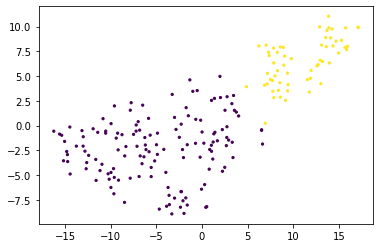

In [13]:
display_tsne(df)

# Classify cells on adherent image

In [14]:
raw_image = cv2.imreadmulti('source_images/Adherent.tif')[1][0]
mask_image = get_mask_image(raw_image, params, mode=mode)
df, masks = extract_features(raw_image, mask_image)
df = process_features(df)
labels = kmeans.predict(df)
print_classification_counts(labels)

Class 0 (yellow): 95 (64.63%)
Class 1 (red): 52 (35.37%)


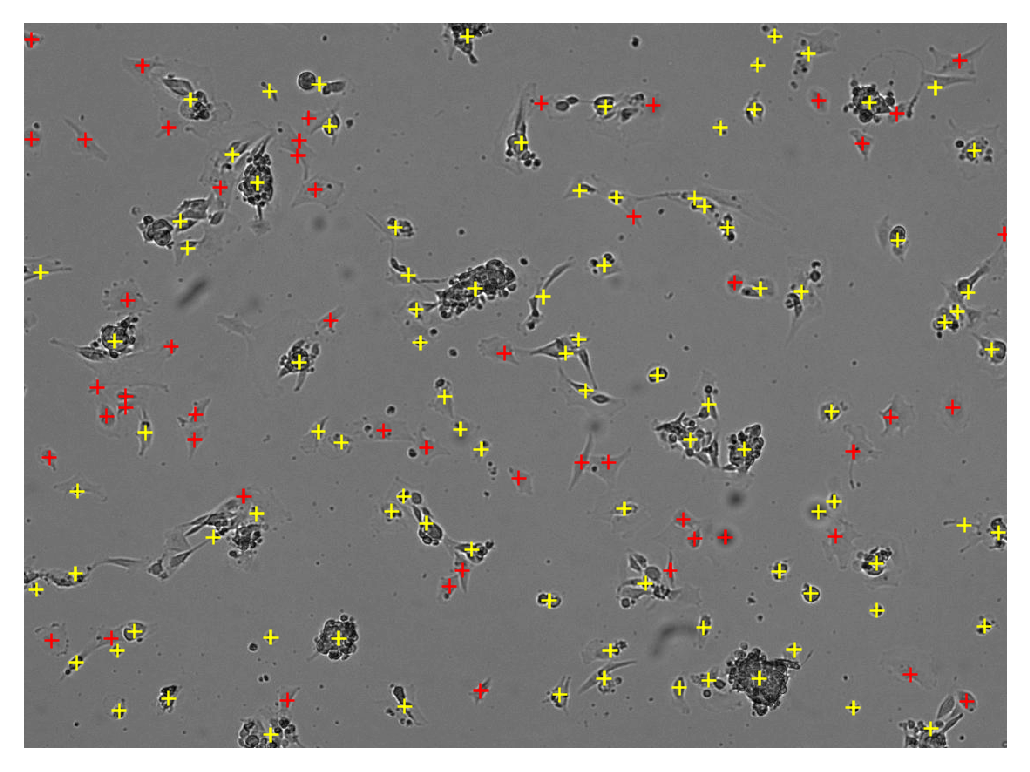

In [15]:
display_classifications(raw_image, df.index, labels)

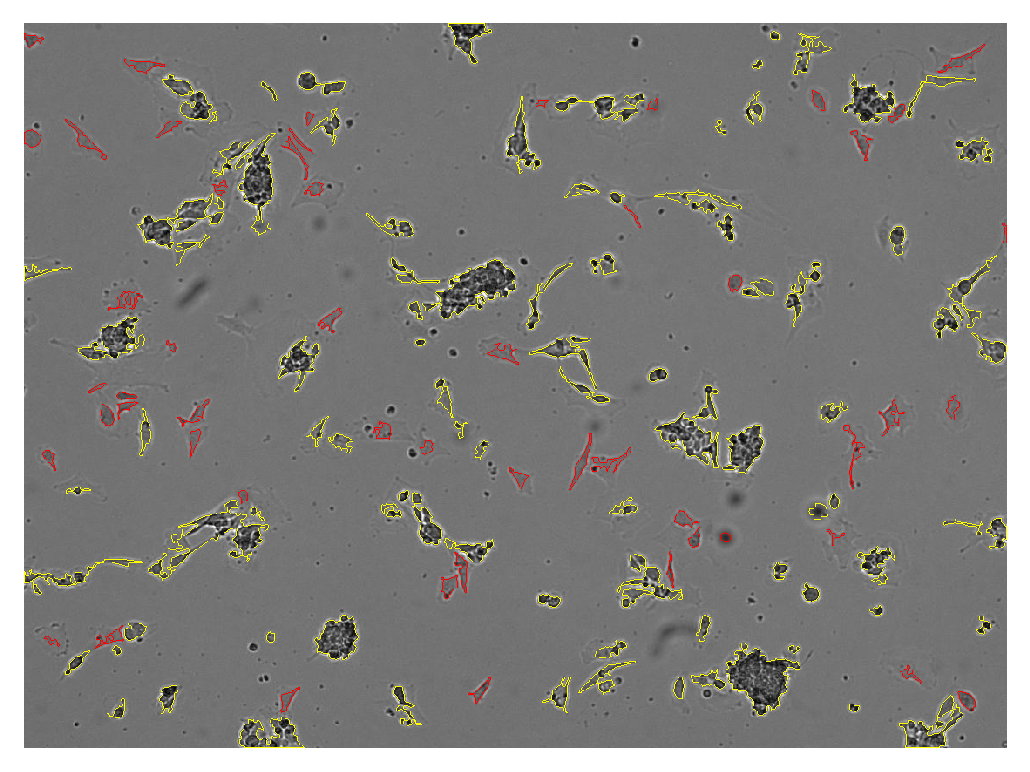

In [16]:
display_contours(raw_image, masks, labels)

Class 0, with 95 ROIs:


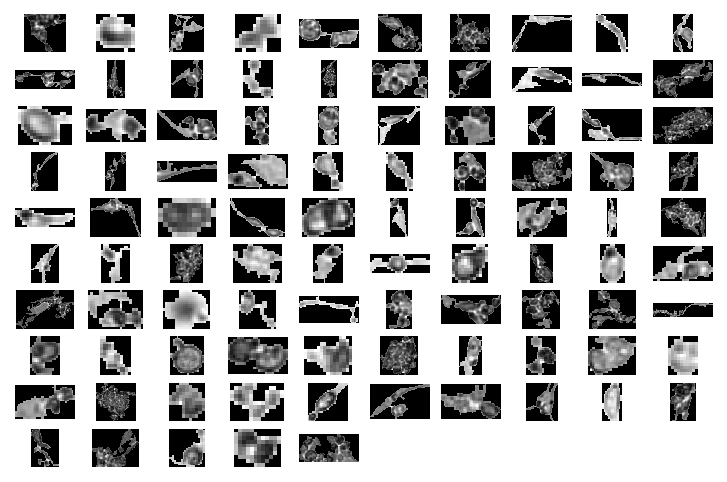

Class 1, with 52 ROIs:


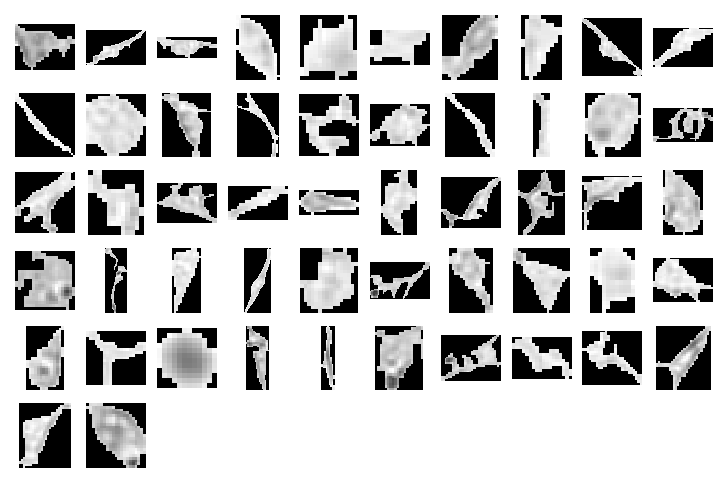

In [17]:
display_rois(raw_image, masks, labels)

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


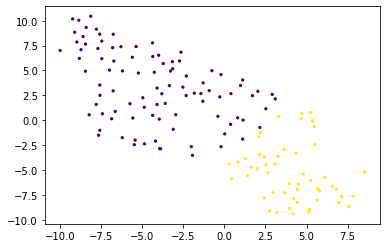

In [18]:
display_tsne(df)

# Classify cells on suspension image

In [19]:
raw_image = cv2.imreadmulti('source_images/Suspension.tif')[1][0]
mask_image = get_mask_image(raw_image, params, mode=mode)
df, masks = extract_features(raw_image, mask_image)
df = process_features(df)
labels = kmeans.predict(df)
print_classification_counts(labels)

Class 0 (yellow): 101 (67.33%)
Class 1 (red): 49 (32.67%)


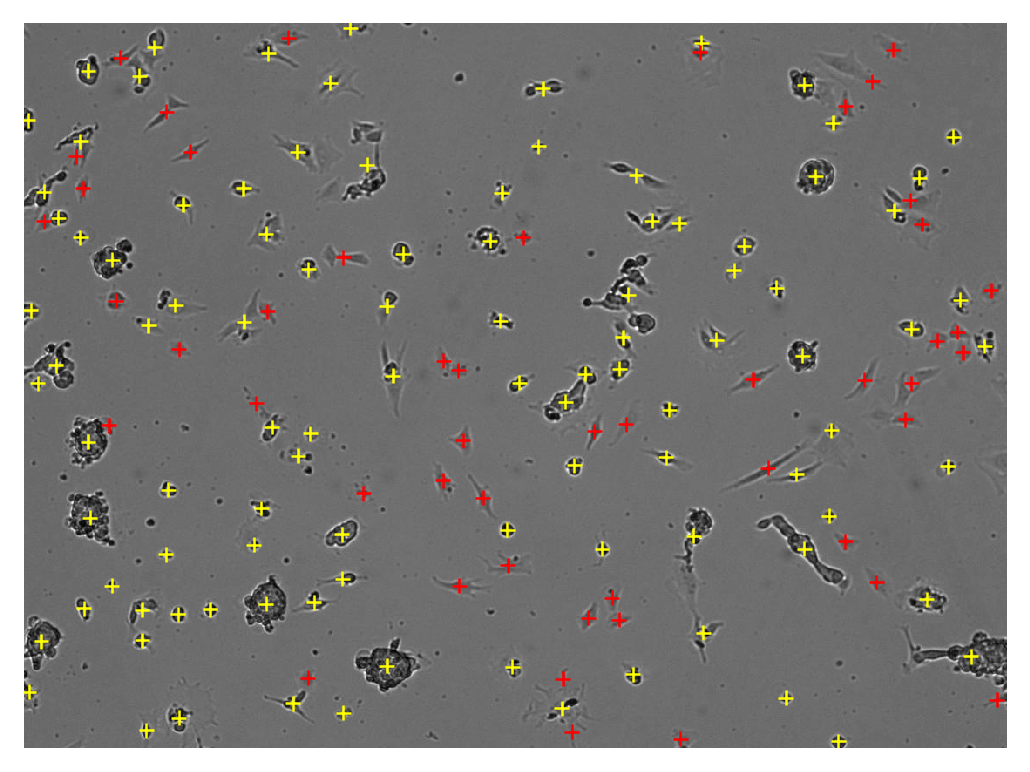

In [20]:
display_classifications(raw_image, df.index, labels)

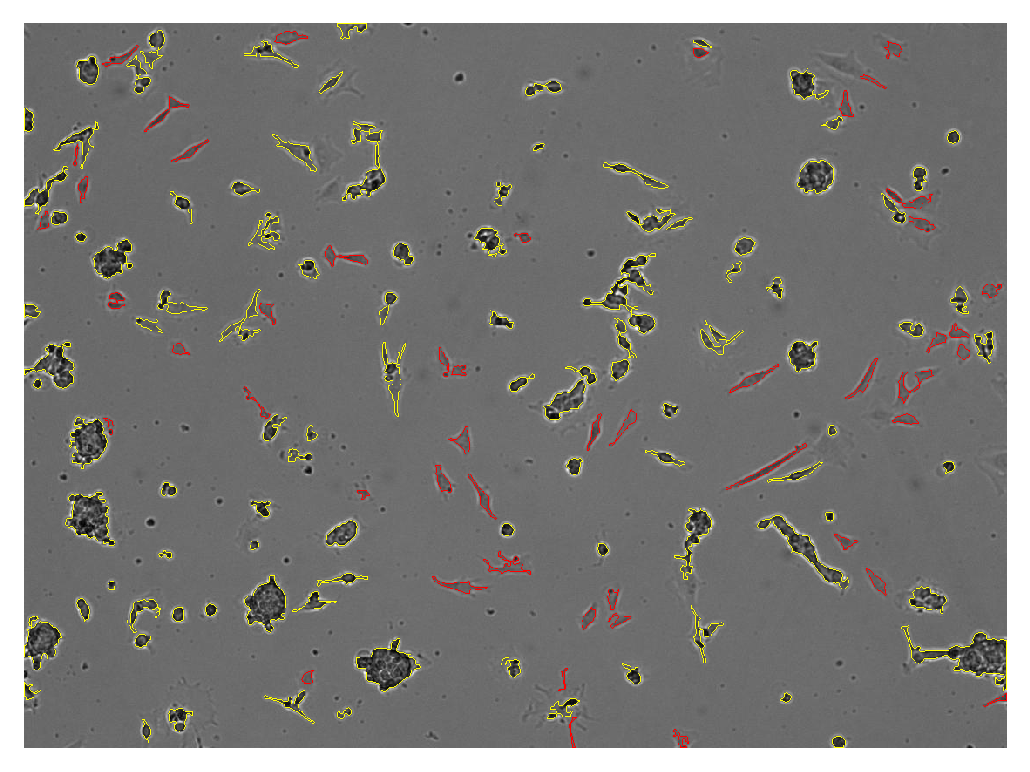

In [21]:
display_contours(raw_image, masks, labels)

Class 0, with 101 ROIs:


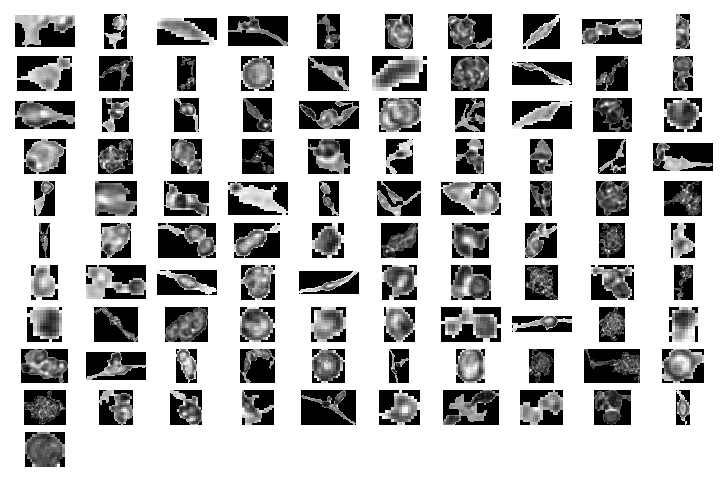

Class 1, with 49 ROIs:


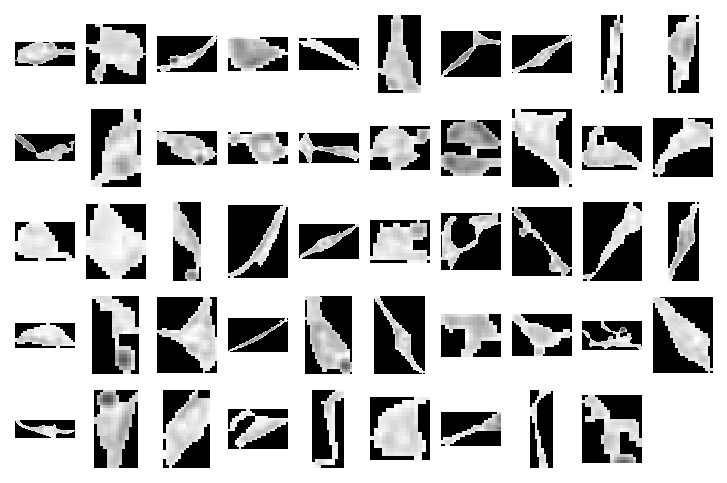

In [22]:
display_rois(raw_image, masks, labels)

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


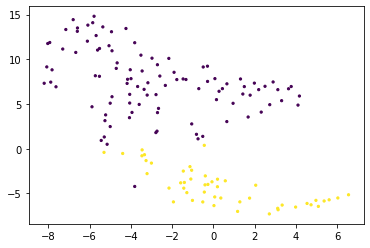

In [23]:
display_tsne(df)

# Experiment w/ multi-Otsu and Canny

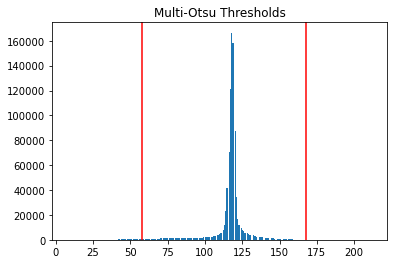

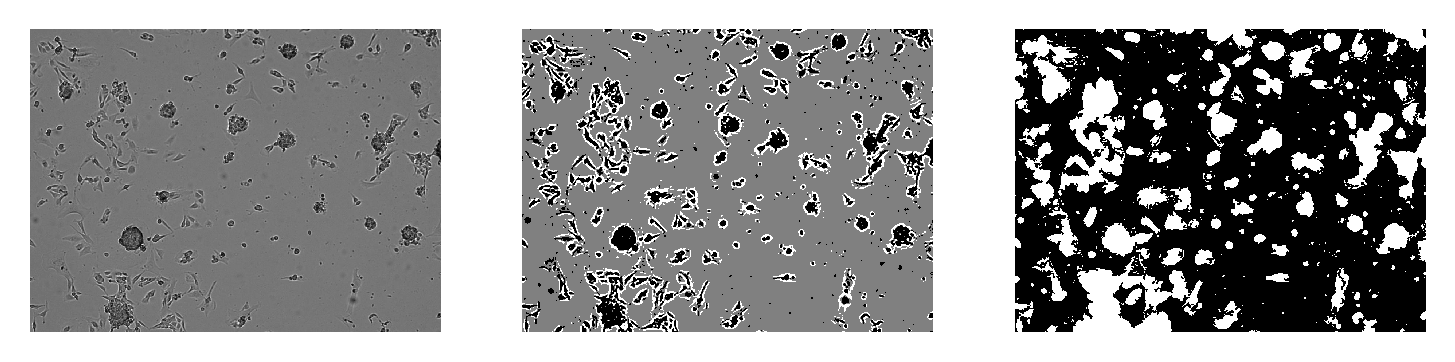

In [24]:
raw_image = cv2.imreadmulti('source_images/Control.tif')[1][0]
blurred = apply_blur(raw_image, 5)
enhanced = apply_contrast(blurred, 10)
thresholds = threshold_multiotsu(enhanced)
multi_otsu_regions = np.digitize(enhanced, bins=thresholds)
merged = np.uint8((multi_otsu_regions - 1) != 0)
filled = apply_imfill(apply_closure(merged, 3))

plt.hist(blurred.ravel(), bins=255)
plt.title('Multi-Otsu Thresholds')
for thresh in thresholds:
    plt.axvline(thresh, color='r')

display_image_array([raw_image, multi_otsu_regions, filled], columns=3, dpi=300)

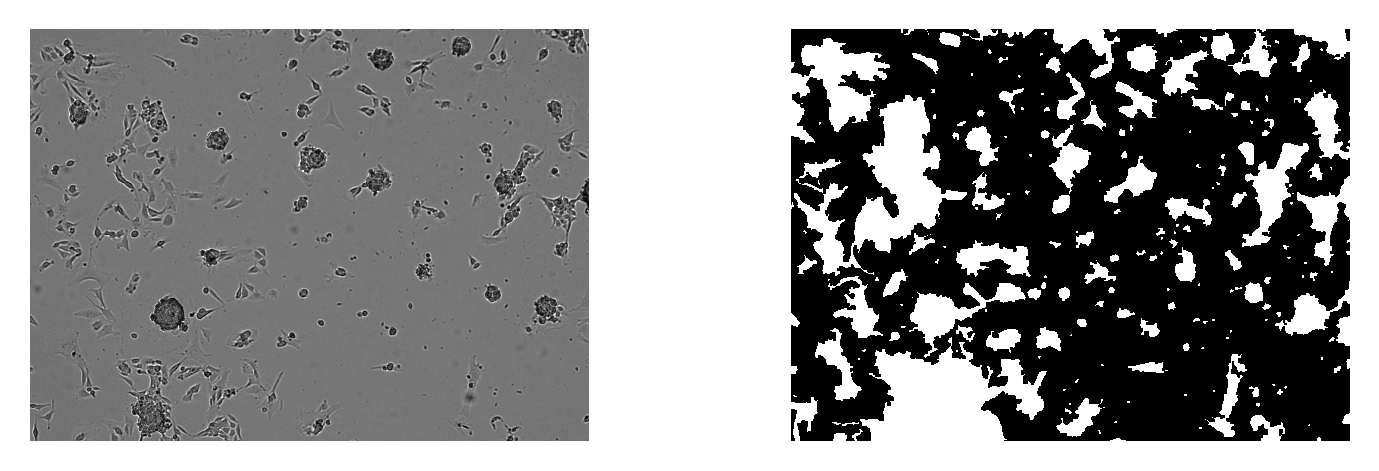

In [25]:
raw_image = cv2.imreadmulti('source_images/Control.tif')[1][0]
enhanced = apply_contrast(raw_image, 2)
canny = apply_canny(enhanced, 40, 180)
filled = apply_imfill(apply_closure(canny, 5))

display_image_array([raw_image, filled], columns=2, dpi=300)